# Dimension Reduction VII: t-Stochastic Neighbors Embedding (t-SNE)
### Implemented in Python

<i>Patrick White</i></br>
<i>Jan 07, 2025</i>

<img src="img/dr7.png" style="height: 450px; width:auto;">

# Outline

- Theoretical Foundation
- Implementation
    - UMAP Speed Test
    - t-SNE Speed Test
- UMAP Parameters
- Advantages and Limitations
- Implementation Details

# Theoretical Foundation

UMAP is a manifold learning technique for dimension reduction, and is similar to t-SNE. It constructs a high-dimensional graph representation of the data and then optimizes a low-dimensional graph to be as structurally similar as possible. Whereas a linear method like PCA can be fast but ignore finer details, and t-SNE preserves more underlying structure but is compute-intensive, UMAP can be seen as a happy compromise between the two, the results of which (with some exceptions) are competitive with t-SNE.

In order to construct the high-dimensional graph, UMAP builds a 'fuzzy simplicial complex': a representation of a weighted graph, with edge weights representing the likelihood that two points are connected. UMAP extends a radius outward from each point, connecting points when the radii overlap. The radius is chosen locally based on the distance to each point's $n^{th}$-nearest neighbor. The graph is made 'fuzzy' by decreasing the likelihood of connection as the radius grows.

One can interpret the <code>n_neighbors</code> parameter as the local scale at which to approximate the manifold as roughly flat. Manifold features that occur at a smaller scale than within the n-nearest neighbors of points will be lost, while large scale features may not be well-detected. Thus, the number of neighbors represents a degree of trade-off between fine-grained and large-scale manifold features.

<code>min_dist</code> directly affects the output, determining how closely points can be packed together in the low-dimensional representation. Low values will result in potentially densely packed regions, but will likely more faithfully represent the manifold structure, whereas increasing <code>min_dist</code> will spread points out more, helping to avoid overplotting issues.

# Implementation

To implement, we can rely on the <code>umap-learn</code> package, which is installed as <code>umap-learn</code> and imported as <code>umap</code>.

In [ ]:
# !pip install umap-learn
import umap

I'll also import <code>matplotlib.pyplot</code> for plotting, and Scikit-Learn’s <code>fetch_openml</code> to grab the 784-dimensional, 70,000 sample MNIST dataset. We’re going to perform a speed comparison against t-SNE, so I’ll also import <code>default_timer</code>.

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='whitegrid')
from sklearn.datasets import fetch_openml
from timeit import default_timer

Then, import the data.

In [4]:
mnist = fetch_openml('mnist_784', version=1, parser='auto')
data = mnist.data
target = mnist.target.astype(int)
data.shape

(70000, 784)

## UMAP Speed Test

Next, I'll run UMAP on the data and time the execution.

In [5]:
start = default_timer()
embedding = umap.UMAP().fit_transform(mnist.data)
end = default_timer()
duration = end - start
print(round(duration,2), 'seconds')

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


107.88 seconds


The computation took about 1 minute and 47 seconds (on Google Colab using the T4 GPU). The results can be visualized as follows:

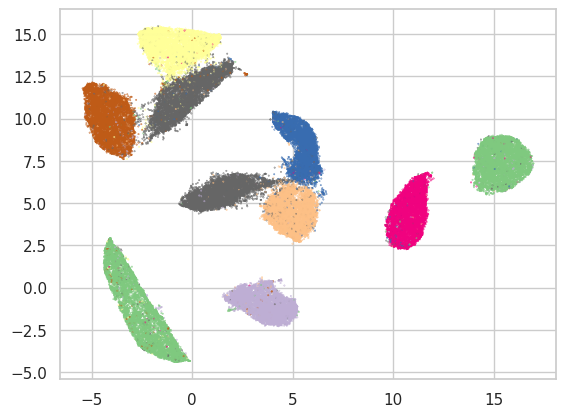

In [7]:
plt.scatter(embedding[:, 0], embedding[:, 1], c=mnist.target.astype(int), s=0.1, cmap=sns.color_palette('Accent', as_cmap=True));

## t-SNE Speed Test

Now, let's try the same with t-SNE.

In [8]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=123)
start = default_timer()
embedding = tsne.fit_transform(data)
end = default_timer()
duration = end - start
print(round(duration,2), 'seconds')

1296.23 seconds


We can see that this took much longer - 1296 seconds works out to 21.6 minutes, over 12x longer than UMAP. The results look different, but can be adjusted with parameter tuning.

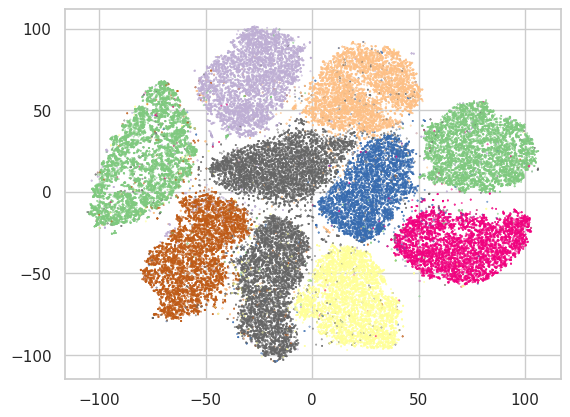

In [9]:
plt.scatter(embedding[:, 0], embedding[:, 1], c=mnist.target.astype(int), s=0.1, cmap=sns.color_palette('Accent', as_cmap=True));

Similar to with t-SNE's <code>perplexity</code> parameter, the <code>min_dist</code> parameter of UMAP can be used to tune the inter-cluster vs. intra-cluster distances in the low-dimensional projection.

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10

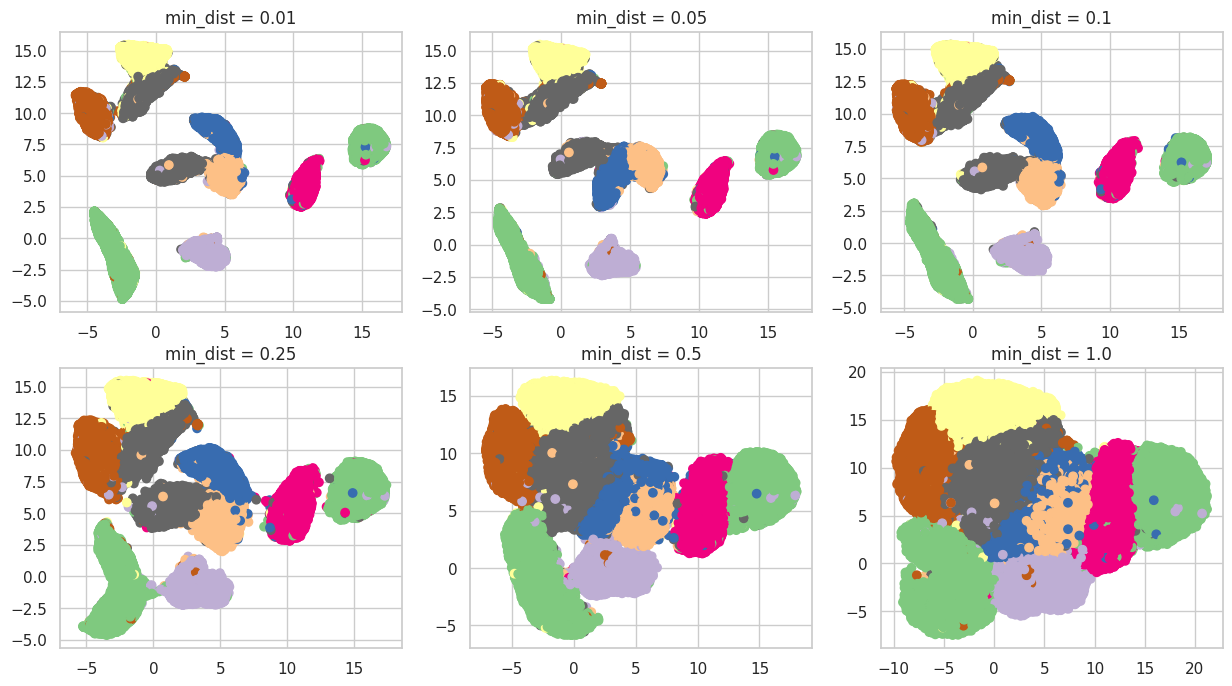

In [11]:
fig, ax = plt.subplots(2, 3, figsize = (15, 8))

min_dists = [ [0.01, 0.05, 0.10], [0.25, 0.50, 1.0] ]

for i in range(2):
    for j in range(3):
        embedded = umap.UMAP(min_dist=min_dists[i][j]).fit_transform(data)
        ax[i][j].scatter(embedded[:,0:1],embedded[:,1:2], c=mnist.target.astype(int), cmap=sns.color_palette('Accent', as_cmap=True))
        ax[i][j].set_title(f"min_dist = {min_dists[i][j]}")
fig.savefig('umap_subplots.png', dpi=300)

One can also play around with the <code>n_neighbors</code> parameter to similar effect. An interesting weakness of UMAP compared to t-SNE is that it has trouble separating a dense nested circle, whereas t-SNE does not.

<img src="img/dr7-4.png" style="height: 300px; width:auto;">

----
<i>"It's worth noting that t-SNE and UMAP wind up performing very similarly on the toy examples from earlier figures, with the notable exception of the following example: A dense, tight cluster inside of a wide, sparse cluster. Interestingly, UMAP is unable to separate two nested clusters, especially when dimensionality is high."</i>
- <a href="https://pair-code.github.io/understanding-umap/?ref=dylancastillo.co">Understanding UMAP</a>, Andy Coenen and Adam Pearce
----

Another interesting effect of UMAP is noted in Leland McInnes' seminal paper on the subject:

----
<i>One of the core assumptions of UMAP is that there exists manifold structure in the data. Because of this UMAP can tend to find manifold structure within the noise of a dataset – similar to the way the human mind finds structured constellations among the stars. As more data is sampled the amount of structure evident from noise will tend to decrease and UMAP becomes more robust, however care must be taken with small sample sizes of noisy data, or data with only large scale manifold structure."</i>
- <a href="https://arxiv.org/pdf/1802.03426v2">UMAP: Uniform Manifold Approximation and Projection for Dimension Reduction</a> (2018), Leland McInnes
----

McInnes created the following visual based on a UMAP of of 30M integers represented by binary vectors of prime divisibility, and observed that the algorithm read into noise around the edges, creating spirals and starbursts.

<img src="img/dr7-5.png" style="height: 500px; width:auto;">

# Advantages and Limitations

Compared to t-SNE, UMAP is much faster, with lower memory usage. Some consider the parameters more intuitive as well. Whereas t-SNE focuses on local structure, UMAP considers both local and global structure, and it utilizes more complex mathematics. t-SNE may better handle small datasets, as UMAP requires a relatively large number of points to accurately construct the manifold. Like t-SNE, UMAP can be very sensitive to parameter choices.

# Implementation Details

## Parameters

- <code>n_neighbors</code> (default=15): the size of the local neighborhood in terms of data points. Larger values result in more global views of the manifold, smaller values result in more local data being preserved.

- <code>n_components</code> (default=2): the dimensionality of space to embed into.

- <code>metric</code> (default='euclidean'): the metric used to compute distances in the high-dimensional space.

- <code>n_epochs</code> (default=None): the number of training epochs to be used in optimizing the low-dimensional representation.

- <code>learning_rate</code> (default=1.0): the initial learning rate for the embedding optimization.

- <code>min_dist</code> (default=0.1): the effective minimum distances between embedded points. Smaller values will result in a more clustered embedding where nearby points on the manifold are drawn closer together, while larger values will result in a more even dispersal.

- <code>spread</code> (default=1.0): the effective scale of embedded points. In combination with min_dist, this determines how clustered the embedded points are.

- <code>local_connectivity</code> (default=1): the number of nearest neighbors that should be assumed to be connected at a local level. The higher the value, the more connected the manifold locally.

- <code>repulsion_strength</code> (default=1.0): weighting applied to negative samples to select per positive sample in the optimization process. Increasing will result in greater repulsive force being applied.

- <code>random_state</code> (default=None): random seed to be used for reproducibility.


## Methods

- <code>fit</code>: fit an instance of the model to the data

- <code>fit_transform</code>: fit an instance of the model to the data, and apply the dimensionality reduction to the data.

- <code>inverse_transform</code>: transform the data back to its original space.

# References

- McInnes, L. (2017). UMAP: Uniform Manifold Approximation and Projection for Dimension Reduction. ArXiv. https://doi.org/1802.03426v2

- Coenen, A., & Pearce, A. (n.d.). Understanding UMAP. PAIR-Code. https://pair-code.github.io/understanding-umap/?ref=dylancastillo.co

- Coenen, A., & Pearce, A. (n.d.). A deeper dive into UMAP theory. PAIR-Code. https://pair-code.github.io/understanding-umap/supplement.html

- How UMAP Works. UMAP User Guide. https://umap-learn.readthedocs.io/en/latest/how_umap_works.html#

- Rudra, A. (2024). Understanding UMAP (Uniform Manifold Approximation and Projection). Medium. https://medium.com/@aeonaten/understanding-umap-uniform-manifold-approximation-and-projection-cede51c477d9